In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from bmis_emg_utils import * 
from tensorflow_model_optimization.quantization.keras import vitis_quantize

In [2]:
subjects = 3
data, label = get_emg_data(subjects)
print('The total data shape is {} and label is {}'.format(data.shape, label.shape))

The total data shape is (8, 199068) and label is (1, 199068)


In [3]:
X, y = window_with_overlap(data, label)
print('The total Input data shape after windowing is {} and label is {}'.format(X.shape, y.shape))

The total Input data shape after windowing is (49757, 8, 40) and label is (49757, 1)


In [4]:
XX_train, yy_train, XX_test, yy_test = spilt_data(X, y, ratio=0.1)
print('Training Set is{} Test Set {}'.format(XX_train.shape, XX_test.shape))

Training Set is(44781, 8, 40) Test Set (4976, 8, 40)


In [5]:
# Expanding the input feature shape

XX_train = np.expand_dims(XX_train, axis=3)
XX_test = np.expand_dims(XX_test, axis=3)
print('Expanded Dimension are {}'.format(XX_train.shape))
input_size = XX_train.shape[1:]
print(input_size)

Expanded Dimension are (44781, 8, 40, 1)
(8, 40, 1)


In [6]:
inputs = tf.keras.Input(shape=input_size)
x = tf.keras.layers.Conv2D(6, 3, activation="relu", input_shape=input_size)(inputs)
x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
x = tf.keras.layers.Conv2D(16, 3, activation="relu")(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1500, activation='relu')(x)
x = tf.keras.layers.Dense(151, activation='relu')(x)
x = tf.keras.layers.Dense(17, activation='relu')(x)
outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="sEMG-classfier")
model.summary()

Model: "sEMG-classfier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 40, 1)]        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 38, 6)          60        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 36, 32)         1760      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 34, 16)         4624      
_________________________________________________________________
flatten (Flatten)            (None, 1088)              0         
_________________________________________________________________
dense (Dense)                (None, 1500)              1633500   
_________________________________________________________________
dense_1 (Dense)              (None, 151)            

In [7]:
lr = 0.001
opt = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-07, clipnorm=1)
ls = 'sparse_categorical_crossentropy'
mtr = 'accuracy'
n_batches = 32
n_epochs = 10
model.compile(optimizer=opt, loss=ls, metrics=mtr)

In [8]:
history = model.fit(XX_train, yy_train, validation_data=(XX_test, yy_test), batch_size=n_batches, epochs= n_epochs)

Epoch 1/10
1400/1400 [==============================] - 19s 14ms/step - loss: 0.8855 - accuracy: 0.6480 - val_loss: 0.5863 - val_accuracy: 0.7757
Epoch 2/10
1400/1400 [==============================] - 18s 13ms/step - loss: 0.4213 - accuracy: 0.8300 - val_loss: 0.4790 - val_accuracy: 0.8183
Epoch 3/10
1400/1400 [==============================] - 18s 13ms/step - loss: 0.2945 - accuracy: 0.8815 - val_loss: 0.2790 - val_accuracy: 0.8923
Epoch 4/10
1400/1400 [==============================] - 18s 13ms/step - loss: 0.2228 - accuracy: 0.9124 - val_loss: 0.2636 - val_accuracy: 0.8965
Epoch 5/10
1400/1400 [==============================] - 18s 13ms/step - loss: 0.1688 - accuracy: 0.9337 - val_loss: 0.3060 - val_accuracy: 0.8869
Epoch 6/10
1400/1400 [==============================] - 18s 13ms/step - loss: 0.1225 - accuracy: 0.9542 - val_loss: 0.2300 - val_accuracy: 0.9256
Epoch 7/10
1400/1400 [==============================] - 16s 12ms/step - loss: 0.0989 - accuracy: 0.9644 - val_loss: 0.2787 -

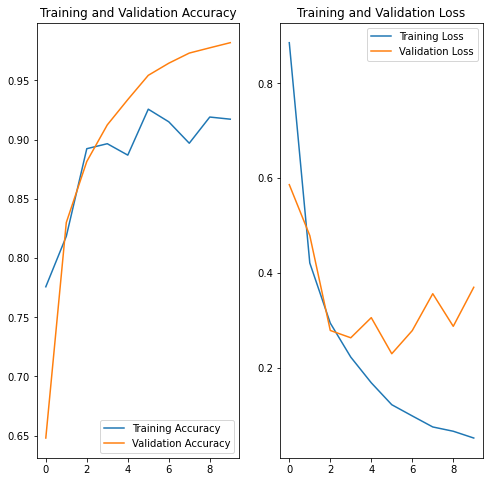

In [9]:
validation_loss = history.history['val_loss']
training_loss = history.history['loss']

validation_accuracy = history.history['accuracy']
training_accuracy = history.history['val_accuracy']

epoch_range = range(n_epochs)
plt.figure(figsize=(8,8))

plt.subplot(1, 2, 1)
plt.plot(epoch_range, training_accuracy, label = "Training Accuracy")
plt.plot(epoch_range, validation_accuracy, label = "Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epoch_range, training_loss, label = "Training Loss")
plt.plot(epoch_range, validation_loss, label = "Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()